In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [5]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import tensorflow as tf

import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random, vmap
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, Sigmoid
from functools import partial

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class MNISTAutoencoder:
    def __init__(self, latent_dim=64, hidden_dims=[512, 256, 128]):
        """
        Pure autoencoder for MNIST compression.
        
        Args:
            latent_dim: Dimension of the compressed latent space
            hidden_dims: List of hidden layer dimensions for encoder
        """
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.setup_networks()
        
    def setup_networks(self):
        """Initialize encoder and decoder networks."""
        # Build encoder layers
        encoder_layers = []
        for hidden_dim in self.hidden_dims:
            encoder_layers.extend([Dense(hidden_dim), Relu])
        # Final layer to latent space (no activation for bottleneck)
        encoder_layers.append(Dense(self.latent_dim))
        
        self.encoder_init, self.encode = stax.serial(*encoder_layers)
        
        # Build decoder layers (reverse of encoder)
        decoder_layers = []
        for hidden_dim in reversed(self.hidden_dims):
            decoder_layers.extend([Dense(hidden_dim), Relu])
        # Final layer to reconstruct input (sigmoid for [0,1] output)
        decoder_layers.extend([Dense(28 * 28), Sigmoid])
        
        self.decoder_init, self.decode = stax.serial(*decoder_layers)
    
    def reconstruction_loss(self, params, images):
        """Mean squared error reconstruction loss."""
        enc_params, dec_params = params
        # Encode to latent space
        latent_code = self.encode(enc_params, images)
        # Decode back to image space
        reconstructed = self.decode(dec_params, latent_code)
        # MSE loss
        return jnp.mean(jnp.sum((images - reconstructed) ** 2, axis=1))
    
    def binary_crossentropy_loss(self, params, images):
        """Binary cross-entropy reconstruction loss (better for binary data)."""
        enc_params, dec_params = params
        latent_code = self.encode(enc_params, images)
        reconstructed = self.decode(dec_params, latent_code)
        
        # Clamp to avoid log(0)
        reconstructed = jnp.clip(reconstructed, 1e-7, 1.0 - 1e-7)
        
        # Binary cross-entropy
        bce = -(images * jnp.log(reconstructed) + (1 - images) * jnp.log(1 - reconstructed))
        return jnp.mean(jnp.sum(bce, axis=1))
    
    def reconstruct_images(self, params, images):
        """Reconstruct images through the autoencoder."""
        enc_params, dec_params = params
        latent_code = self.encode(enc_params, images)
        reconstructed = self.decode(dec_params, latent_code)
        return reconstructed
    
    def encode_images(self, params, images):
        """Encode images to latent space."""
        enc_params, _ = params
        return self.encode(enc_params, images)
    
    def decode_latent(self, params, latent_codes):
        """Decode latent codes to images."""
        _, dec_params = params
        return self.decode(dec_params, latent_codes)
    
    def get_compression_ratio(self):
        """Calculate compression ratio."""
        original_size = 28 * 28  # 784 pixels
        compressed_size = self.latent_dim
        compression_ratio = original_size / compressed_size
        return compression_ratio
    
    def create_image_grid(self, nrow, ncol, imagevecs, imshape=(28, 28)):
        """Create a grid of images for visualization."""
        images = iter(imagevecs.reshape((-1,) + imshape))
        return jnp.vstack([
            jnp.hstack([next(images).T for _ in range(ncol)][::-1])
            for _ in range(nrow)
        ]).T

class Trainer:
    def __init__(self, model, step_size=0.001, momentum=0.9, loss_type='mse'):
        """
        Args:
            loss_type: 'mse' for mean squared error or 'bce' for binary cross-entropy
        """
        self.model = model
        self.loss_type = loss_type
        self.opt_init, self.opt_update, self.get_params = optimizers.momentum(
            step_size, mass=momentum
        )
        self.history = {
            'train_loss': [],
            'test_loss': []
        }
        
        # Choose loss function
        if loss_type == 'mse':
            self.loss_fn = model.reconstruction_loss
        elif loss_type == 'bce':
            self.loss_fn = model.binary_crossentropy_loss
        else:
            raise ValueError("loss_type must be 'mse' or 'bce'")
    
    @partial(jax.jit, static_argnames=['self'])
    def train_step(self, opt_state, batch):
        """Single training step."""
        params = self.get_params(opt_state)
        loss, grads = jax.value_and_grad(self.loss_fn)(params, batch)
        opt_state = self.opt_update(0, grads, opt_state)
        return opt_state, loss
    
    def train_epoch(self, opt_state, images, batch_size):
        """Train for one epoch."""
        num_batches = (images.shape[0] + batch_size - 1) // batch_size
        total_loss = 0.0
        
        # Shuffle data
        rng = random.key(int(time.time()))
        perm = random.permutation(rng, images.shape[0])
        images_shuffled = images[perm]
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, images.shape[0])
            batch = images_shuffled[start_idx:end_idx]
            
            opt_state, loss = self.train_step(opt_state, batch)
            total_loss += loss
        
        return opt_state, total_loss / num_batches
    
    @partial(jax.jit, static_argnames=['self'])
    def evaluate(self, opt_state, images, batch_size=1000):
        """Evaluate the model."""
        params = self.get_params(opt_state)
        total_loss = 0.0
        num_batches = (images.shape[0] + batch_size - 1) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, images.shape[0])
            batch = images[start_idx:end_idx]
            
            loss = self.loss_fn(params, batch)
            total_loss += loss * batch.shape[0]
        
        return total_loss / images.shape[0]

class Visualizer:
    def __init__(self, model):
        self.model = model
    
    def plot_training_history(self, history, save_path=None):
        """Plot training history."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        ax.plot(history['train_loss'], 'b-', alpha=0.8, label='Training Loss')
        ax.plot(history['test_loss'], 'r-', alpha=0.8, label='Test Loss')
        ax.set_title('Training History', fontsize=16)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Reconstruction Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_reconstructions(self, params, test_images, num_examples=10, save_path=None):
        """Plot original vs reconstructed images."""
        # Select random images
        indices = np.random.choice(test_images.shape[0], num_examples, replace=False)
        original_images = test_images[indices]
        reconstructed = self.model.reconstruct_images(params, original_images)
        
        fig, axes = plt.subplots(2, num_examples, figsize=(20, 4))
        fig.suptitle('Original vs Reconstructed Images', fontsize=16)
        
        for i in range(num_examples):
            # Original images
            axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
            axes[1, i].set_title(f'Reconstructed {i+1}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_latent_space(self, params, test_images, test_labels, save_path=None):
        """Visualize latent space (works best with 2D latent space)."""
        if self.model.latent_dim != 2:
            print(f"Latent space visualization works best with 2D latent space. "
                  f"Current latent dim: {self.model.latent_dim}")
            return
        
        # Encode test images
        latent_codes = self.model.encode_images(params, test_images)
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_codes[:, 0], latent_codes[:, 1], c=test_labels, 
                            cmap='tab10', alpha=0.6, s=20)
        plt.colorbar(scatter)
        plt.title('Latent Space Representation', fontsize=16)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_latent_interpolation(self, params, test_images, n_steps=10, save_path=None):
        """Generate interpolation between two test images in latent space."""
        # Select two random test images
        indices = np.random.choice(test_images.shape[0], 2, replace=False)
        img1, img2 = test_images[indices[0]:indices[0]+1], test_images[indices[1]:indices[1]+1]
        
        # Encode to latent space
        z1 = self.model.encode_images(params, img1)
        z2 = self.model.encode_images(params, img2)
        
        # Create interpolation
        alphas = jnp.linspace(0, 1, n_steps)
        interpolated_z = jnp.array([alpha * z2 + (1 - alpha) * z1 for alpha in alphas])
        interpolated_z = interpolated_z.reshape(-1, self.model.latent_dim)
        
        # Decode interpolated points
        generated_images = self.model.decode_latent(params, interpolated_z)
        
        # Plot
        fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
        fig.suptitle('Latent Space Interpolation', fontsize=16)
        
        for i in range(n_steps):
            axes[i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
            axes[i].set_title(f'α={alphas[i]:.2f}')
            axes[i].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_compression(self, params, test_images, num_samples=100):
        """Analyze compression quality and statistics."""
        # Select random samples
        indices = np.random.choice(test_images.shape[0], num_samples, replace=False)
        sample_images = test_images[indices]
        
        # Get reconstructions
        reconstructed = self.model.reconstruct_images(params, sample_images)
        
        # Calculate metrics
        mse_per_image = jnp.mean((sample_images - reconstructed) ** 2, axis=1)
        mean_mse = jnp.mean(mse_per_image)
        std_mse = jnp.std(mse_per_image)
        
        # Calculate PSNR (Peak Signal-to-Noise Ratio)
        psnr_per_image = 20 * jnp.log10(1.0 / jnp.sqrt(mse_per_image))
        mean_psnr = jnp.mean(psnr_per_image)
        
        compression_ratio = self.model.get_compression_ratio()
        
        print("=" * 50)
        print("COMPRESSION ANALYSIS")
        print("=" * 50)
        print(f"Latent Dimension: {self.model.latent_dim}")
        print(f"Compression Ratio: {compression_ratio:.2f}:1")
        print(f"Original Size: {28*28} pixels")
        print(f"Compressed Size: {self.model.latent_dim} values")
        print(f"Mean MSE: {mean_mse:.6f} ± {std_mse:.6f}")
        print(f"Mean PSNR: {mean_psnr:.2f} dB")
        print("=" * 50)

def load_mnist_data():
    """Load MNIST data using TensorFlow and convert to JAX format."""
    # Load MNIST dataset from TensorFlow
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255
    
    # Flatten images to vectors
    x_train = x_train.reshape(x_train.shape[0], -1)  # (60000, 784)
    x_test = x_test.reshape(x_test.shape[0], -1)     # (10000, 784)
    
    # Convert to JAX arrays
    x_train = jnp.array(x_train)
    x_test = jnp.array(x_test)
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test labels shape: {y_test.shape}")
    
    return x_train, y_train, x_test, y_test


# Hyperparameters
step_size = 0.001
num_epochs = 500
batch_size = 128
latent_dim = 64  # Compression bottleneck
hidden_dims = [512, 256, 128]  # Encoder architecture
loss_type = 'mse'  # 'mse' or 'bce'

# Initialize model and trainer
model = MNISTAutoencoder(latent_dim=latent_dim, hidden_dims=hidden_dims)
trainer = Trainer(model, step_size=step_size, loss_type=loss_type)
visualizer = Visualizer(model)

print(f"Compression ratio: {model.get_compression_ratio():.2f}:1")

# Load data
print("Loading MNIST data...")
train_images, train_labels, test_images, test_labels = load_mnist_data()

# Move data to device
train_images = jax.device_put(train_images)
test_images = jax.device_put(test_images)

# Initialize parameters
print("Initializing parameters...")
enc_init_rng, dec_init_rng = random.split(random.key(42))
_, init_encoder_params = model.encoder_init(enc_init_rng, (batch_size, 28 * 28))
_, init_decoder_params = model.decoder_init(dec_init_rng, (batch_size, latent_dim))
init_params = init_encoder_params, init_decoder_params

opt_state = trainer.opt_init(init_params)

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    tic = time.time()
    
    # Train
    opt_state, train_loss = trainer.train_epoch(opt_state, train_images, batch_size)
    
    # Evaluate
    test_loss = trainer.evaluate(opt_state, test_images)
    
    # Store history
    trainer.history['train_loss'].append(float(train_loss))
    trainer.history['test_loss'].append(float(test_loss))
    
    # Print progress
    elapsed = time.time() - tic
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | "
            f"Test Loss: {test_loss:.6f} | Time: {elapsed:.2f}s")

# Final visualizations and analysis
print("\nTraining completed! Generating visualizations...")
final_params = trainer.get_params(opt_state)



Compression ratio: 12.25:1
Loading MNIST data...
Training data shape: (60000, 784)
Test data shape: (10000, 784)
Training labels shape: (60000,)
Test labels shape: (10000,)
Initializing parameters...
Starting training...
Epoch   0 | Train Loss: 54.497990 | Test Loss: 34.237213 | Time: 3.72s
Epoch   1 | Train Loss: 25.434467 | Test Loss: 19.385155 | Time: 0.16s
Epoch   2 | Train Loss: 17.167936 | Test Loss: 14.820166 | Time: 0.18s
Epoch   3 | Train Loss: 14.007960 | Test Loss: 12.358360 | Time: 0.17s
Epoch   4 | Train Loss: 11.955952 | Test Loss: 10.954662 | Time: 0.16s
Epoch   5 | Train Loss: 10.738253 | Test Loss: 10.044240 | Time: 0.18s
Epoch   6 | Train Loss: 9.846370 | Test Loss: 9.197714 | Time: 0.16s
Epoch   7 | Train Loss: 9.057834 | Test Loss: 8.446894 | Time: 0.17s
Epoch   8 | Train Loss: 8.483954 | Test Loss: 8.172266 | Time: 0.16s
Epoch   9 | Train Loss: 8.034634 | Test Loss: 7.758162 | Time: 0.18s
Epoch  10 | Train Loss: 7.662063 | Test Loss: 7.430159 | Time: 0.16s
Epoch  1

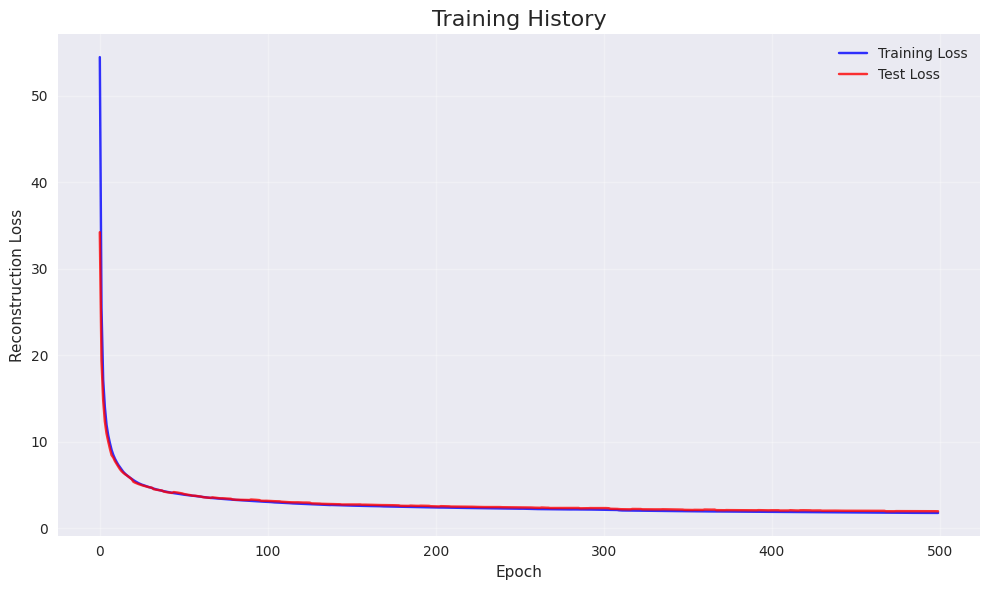

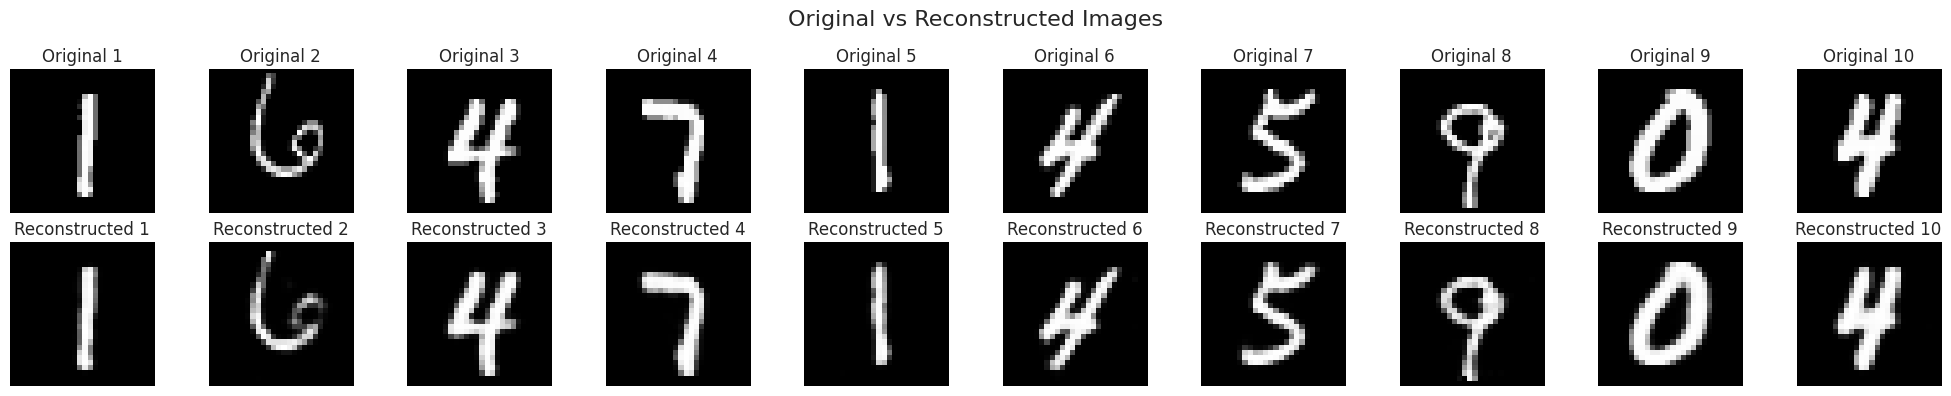

COMPRESSION ANALYSIS
Latent Dimension: 64
Compression Ratio: 12.25:1
Original Size: 784 pixels
Compressed Size: 64 values
Mean MSE: 0.002499 ± 0.001660
Mean PSNR: 26.97 dB


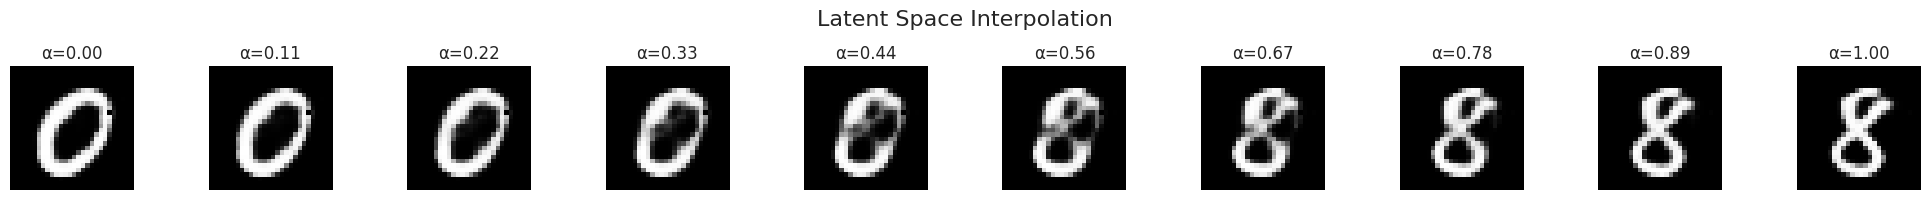

All visualizations complete!


In [10]:
# Plot training history
visualizer.plot_training_history(trainer.history)

# Plot reconstructions
visualizer.plot_reconstructions(final_params, test_images, num_examples=10)

# Analyze compression performance
visualizer.analyze_compression(final_params, test_images, num_samples=1000)

# Plot latent space (if 2D)
if latent_dim == 2:
    visualizer.plot_latent_space(final_params, test_images[:1000], 
                                test_labels[:1000])

# Plot latent interpolation
visualizer.plot_latent_interpolation(final_params, test_images, n_steps=10)

print("All visualizations complete!")

## Numbers

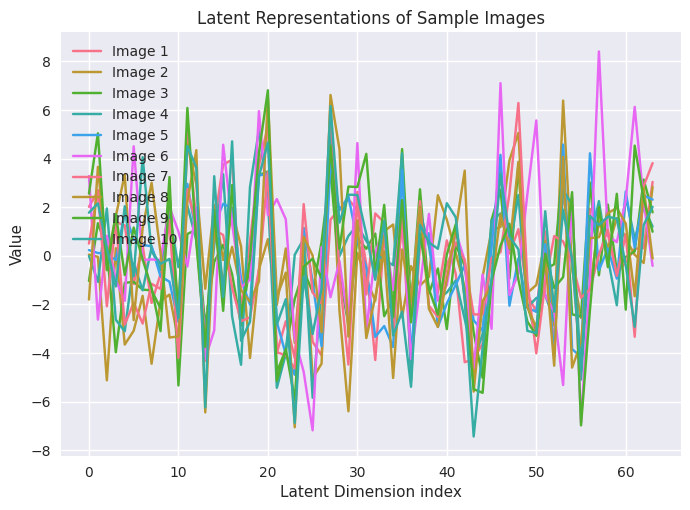

In [7]:
test_images_digit_4 = test_images[test_labels == 4]

for i in range(10):
    plt.plot(np.arange(latent_dim), model.encode_images(final_params, test_images_digit_4)[i,...], label=f'Image {i+1}')
plt.title('Latent Representations of Sample Images')
plt.xlabel('Latent Dimension index')
plt.ylabel('Value')
plt.legend()

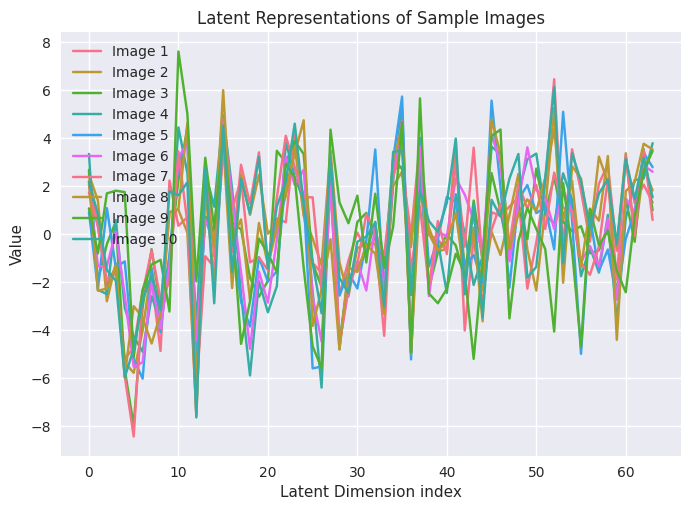

In [8]:
test_images_digit_1 = test_images[test_labels == 1]

for i in range(10):
    plt.plot(np.arange(latent_dim), model.encode_images(final_params, test_images_digit_1)[i,...], label=f'Image {i+1}')
plt.title('Latent Representations of Sample Images')
plt.xlabel('Latent Dimension index')
plt.ylabel('Value')
plt.legend()

#  svd analysis

Latent data shape: (10000, 64)
U shape: (10000, 64)
Singular values shape: (64,)
V transpose shape: (64, 64)


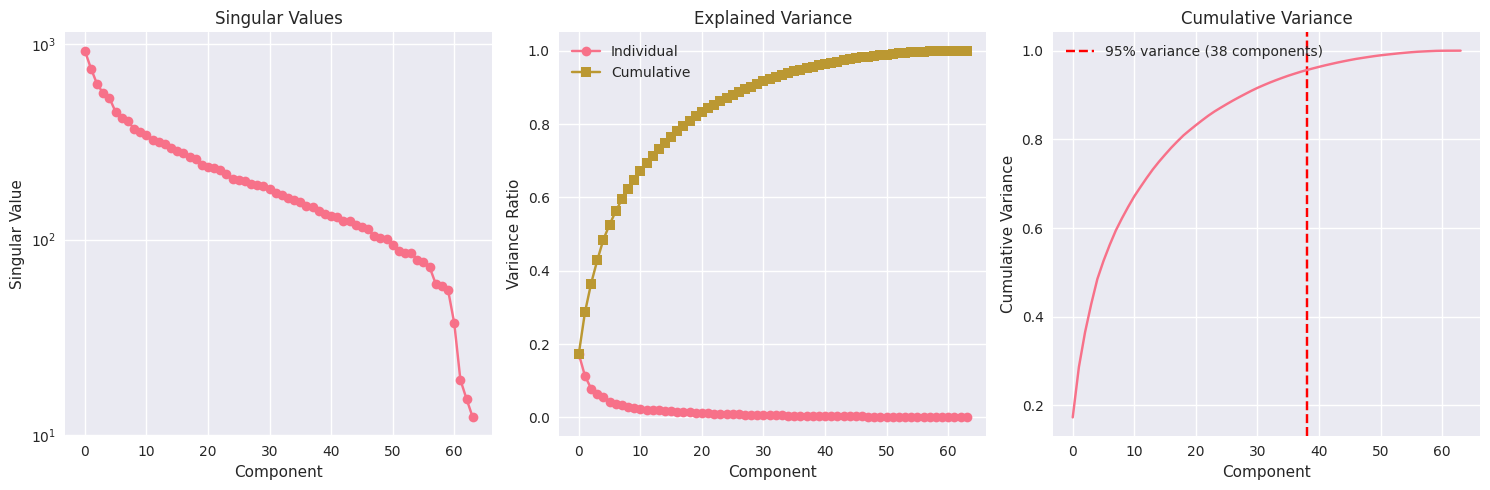


SVD Analysis Results:
Total components: 64
Components for 90% variance: 29
Components for 95% variance: 38
Components for 99% variance: 52
Effective dimensionality: 49.15
Reconstruction error with 10 components: 2.722886
Reconstruction error with 50 components: 0.094760
Reconstruction error with 64 components: 0.000000


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Encode your test images to latent space
latent_data = model.encode_images(final_params, test_images)
print(f"Latent data shape: {latent_data.shape}")

# Perform SVD
U, s, Vt = np.linalg.svd(latent_data, full_matrices=False)

print(f"U shape: {U.shape}")
print(f"Singular values shape: {s.shape}")
print(f"V transpose shape: {Vt.shape}")

# Analyze the singular values
plt.figure(figsize=(15, 5))

# Plot 1: Singular values
plt.subplot(1, 3, 1)
plt.plot(s, 'o-')
plt.title('Singular Values')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.yscale('log')

# Plot 2: Explained variance ratio
variance_explained = (s**2) / np.sum(s**2)
cumulative_variance = np.cumsum(variance_explained)

plt.subplot(1, 3, 2)
plt.plot(variance_explained, 'o-', label='Individual')
plt.plot(cumulative_variance, 's-', label='Cumulative')
plt.title('Explained Variance')
plt.xlabel('Component')
plt.ylabel('Variance Ratio')
plt.legend()

# Plot 3: Effective dimensionality
plt.subplot(1, 3, 3)
# Find components that explain 95% of variance
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
plt.axvline(n_components_95, color='red', linestyle='--', 
           label=f'95% variance ({n_components_95} components)')
plt.plot(cumulative_variance)
plt.title('Cumulative Variance')
plt.xlabel('Component')
plt.ylabel('Cumulative Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Print key statistics
print(f"\nSVD Analysis Results:")
print(f"Total components: {len(s)}")
print(f"Components for 90% variance: {np.where(cumulative_variance >= 0.90)[0][0] + 1}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 99% variance: {np.where(cumulative_variance >= 0.99)[0][0] + 1}")

# Effective dimensionality (using entropy-based measure)
normalized_s = s / np.sum(s)
effective_dim = np.exp(-np.sum(normalized_s * np.log(normalized_s + 1e-12)))
print(f"Effective dimensionality: {effective_dim:.2f}")

# Dimensionality reduction example
def reconstruct_with_k_components(k):
    """Reconstruct data using only first k components"""
    return U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

# Example: reconstruct with different numbers of components
k_values = [10, 50, 100, min(200, len(s))]
reconstruction_errors = []

for k in k_values:
    if k <= len(s):
        reconstructed = reconstruct_with_k_components(k)
        error = np.mean((latent_data - reconstructed)**2)
        reconstruction_errors.append(error)
        print(f"Reconstruction error with {k} components: {error:.6f}")

